# Probabilistic Programming

A Probabilistic Programming Language (PPL) is a computer language providing statistical modelling and inference functionalities, in order to reason about random variables, probability distributions and conditioning problems. The most popular PPLs are `Stan`, `PyMC`, `Pyro` and `Edward`. 

A probabilistic program is a mix of **deterministic computation** and **sampling**, which allows to *draw random values* from distributions, to *condition* variables on observations and to perform *inference*.

### Pyro
Pyro is a universal probabilistic programming language based on Python.

It can represent any probabilistic model, while providing automatic optimization-based inference that is flexible and scalable to large data sets. 
Pyro builds on PyTorch library, which supports GPU-accelerated tensor math and includes automatic differentiation, a technique for efficiently computing gradients.


### Models
The basic unit of probabilistic programs is the stochastic function (or model). A statistical model is a mathematical description of how the values of some knowns and unknowns could generate the observed data.

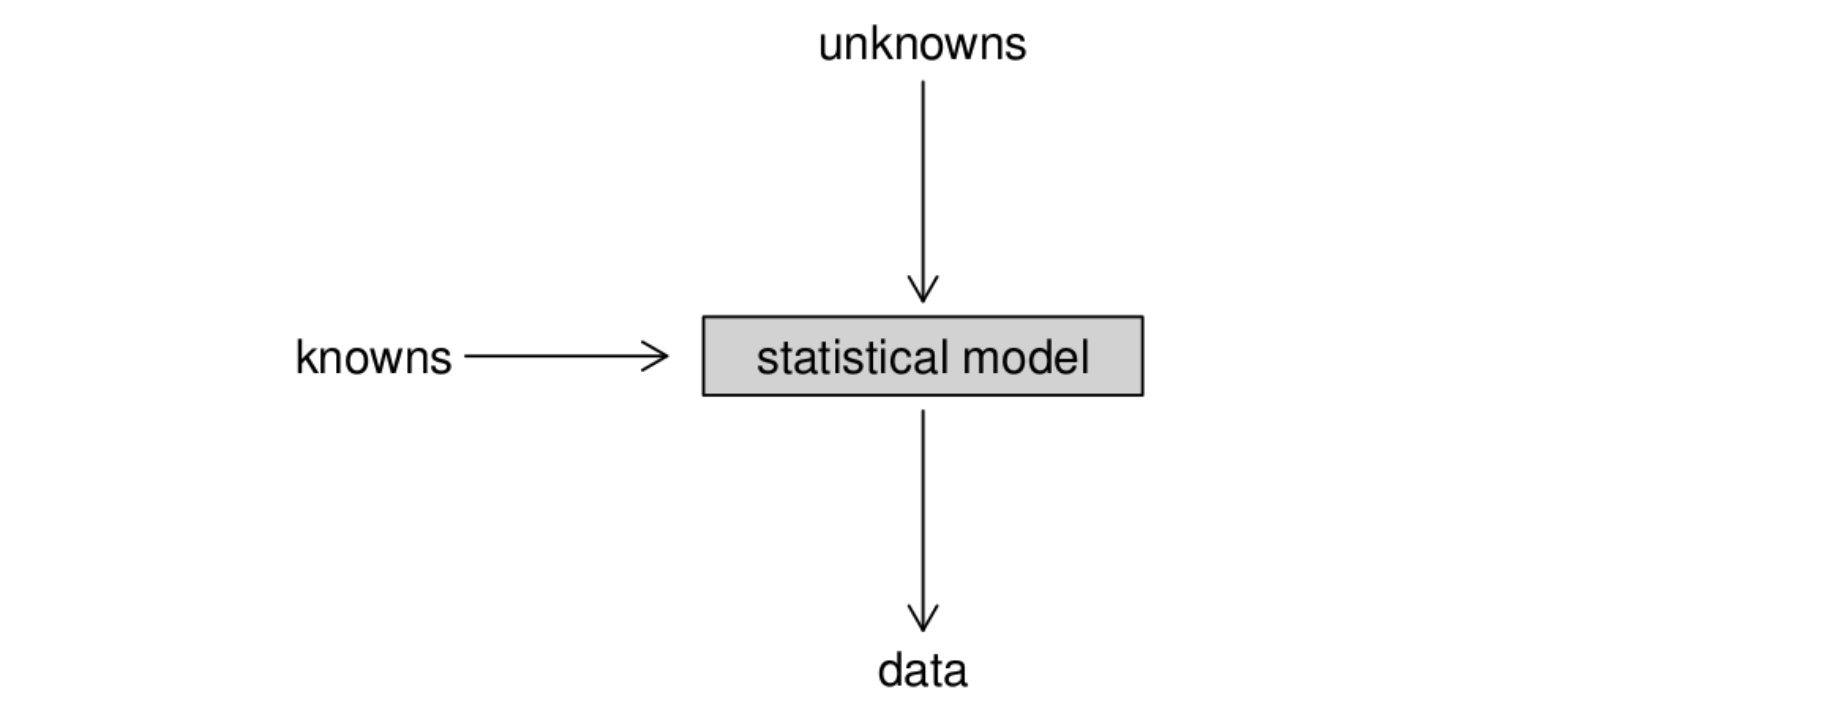
<div align="center" style="color:darkblue">S. Wood, "Core Statistics"</div>


A stochastic function in Python is an arbitrary function that combines two ingredients:

- deterministic Python code
- primitive stochastic functions that call a random number generator

**Using `sample()` primitive** 

Drawing a sample from the unit normal distribution $\mathcal{N}(0,1)$.

In [1]:
import torch
import pyro
pyro.set_rng_seed(1) # for reproducibility

loc = 0. # mean 
scale = 1. # standard deviation

# using pytorch
normal = torch.distributions.Normal(loc, scale) # create a normal distribution object
x = normal.rsample() # draw a sample from N(0,1)
print("pytorch sample:\t", x)

# using pyro
x = pyro.sample("sample_name", pyro.distributions.Normal(loc, scale))

print("pyro sample:\t", x)

pytorch sample:	 tensor(0.6614)
pyro sample:	 tensor(0.2669)


Pyro samples are named: Pytorch backend uses these names to uniquely identify sample statements and change their behavior at runtime depending on how the enclosing stochastic function is being used.

**Drawing multiple samples**

Now we draw multiple samples from $\mathcal{N}(2,2)$ and $\text{Exp}(0.3)$ distributions and plot the corresponding histograms.

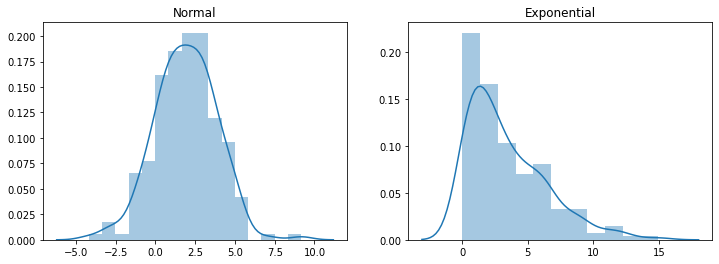

In [2]:
import seaborn as sns 
import matplotlib.pyplot as plt
import pyro.distributions as dist

# distributions
normal =  dist.Normal(2, 2)
exp = dist.Exponential(0.3)

# multiple samples
normal_samples = [pyro.sample("n",normal) for i in range(200)]
exp_samples = [pyro.sample("n",exp) for i in range(200)]

#plot
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.distplot(normal_samples, ax=axes[0])
sns.distplot(exp_samples, ax=axes[1])
axes[0].set_title('Normal')
axes[1].set_title('Exponential')
plt.show()

Seaborn `distplot()` automatically estimates the PDFs over histogram bins.

**Simple stochastic model**

Suppose we want to reason about how temperature interacts with sunny and cloudy weather. We can define a simple stochastic function `weather()` describing the interaction


$$ \mathcal{N}(12.0,5.0^2) \; \text{for cloudy weather}$$
 
$$\mathcal{N}(23.0,6.0^2) \; \text{for sunny weather} \; $$

In [3]:
def weather():
    # generate a binary sample
    is_cloudy = pyro.sample('cloudy', dist.Bernoulli(0.3))
    
    # convert binary sample into categorical
    is_cloudy = 'cloudy' if is_cloudy.item() == 1.0 else 'sunny'
    
    loc_temp = {'cloudy': 12.0, 'sunny': 23.0}[is_cloudy]
    scale_temp = {'cloudy': 5.0, 'sunny': 6.0}[is_cloudy]
    temp = pyro.sample('temp', dist.Normal(loc_temp, scale_temp))
    
    return {"weather":is_cloudy, "temp":temp.item()}

[weather() for _ in range(5)]

[{'weather': 'cloudy', 'temp': 8.512848854064941},
 {'weather': 'cloudy', 'temp': 12.010722160339355},
 {'weather': 'sunny', 'temp': 19.3258056640625},
 {'weather': 'sunny', 'temp': 14.052600860595703},
 {'weather': 'sunny', 'temp': 32.76374816894531}]

We could use this stochastic function to model the sales of ice cream based on the weather.

In [4]:
def ice_cream_sales():
    is_cloudy, temp = weather()
    expected_sales = 200. if is_cloudy == 1 and temp > 35.0 else 20.
    sales = pyro.sample('ice_cream', pyro.distributions.Normal(expected_sales, 10.0))
    return sales

[ice_cream_sales() for _ in range(5)]

[tensor(31.2418),
 tensor(36.3404),
 tensor(18.3335),
 tensor(23.0716),
 tensor(7.7725)]

## Inference

The purpose of statistical inference is that of using a statistical model to infer the values of the unknowns that are consistent with the observed data.


|Frequentist interpretation|Bayesian interpretation|
|:-:|:-:|
|Probability measures a proportion of outcomes. | Probability measures the believability in an event. |
|There is randomness in our estimation of the parameters, but not in the parameters themselves, which are considered as fixed.| Parameters are treated as random variables and our belief about these parameters is updated in the light of data.|



### Bayesian inference


**Bayes theorem**

Let $A$ and $B$ be two events, such that $P(B)\neq0$, then $
P(A|B) = \frac{P(A,B)}{P(B)}=\frac{P(B|A)P(A)}{P(B)}$.


<div> 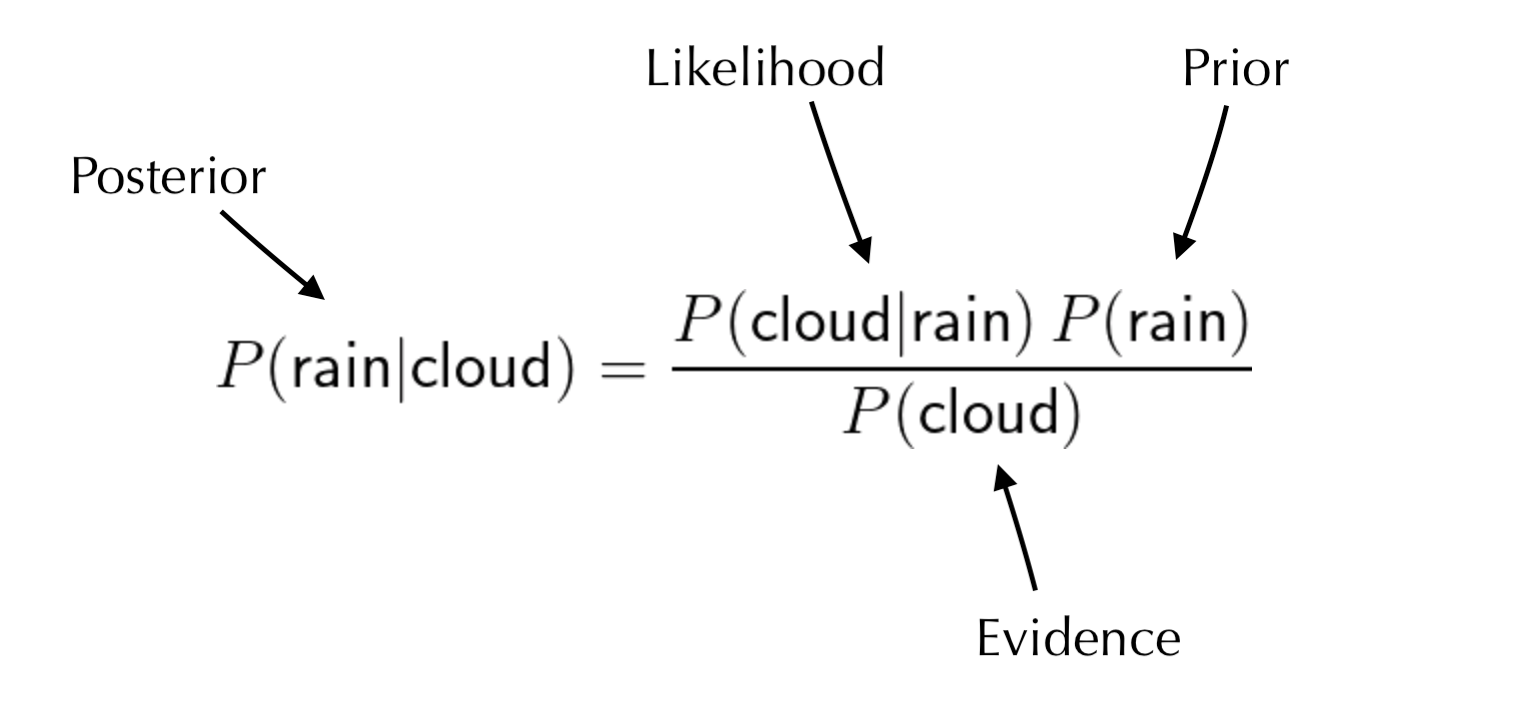</div>
<div align="center" style="color:darkblue">https://medium.com/informatics-lab/probabilistic-programming-1535d7882dbe</div>

**Bayes theorem example**

There are two boxes $b_1$ and $b_2$. Box 1 contains three red and five white balls and box 2 contains two red and five white balls. A box $B\in\{b1,b2\}$ is chosen at random with $P(B=b_1)=P(B=b_2)=0.5$ and a ball chosen at random from this box turns out to be red. 
What is the posterior probability that the red ball came from box 1?

$R\in\{0,1\}$ indicates whether the chosen ball is red or not.

From Bayes theorem we get 
$$
P(B=b_1|R=1)=\frac{P(B=b_1,R=1)}{P(R=1)}.
$$

and $P(B=b_1,R=1) = P(R=1|B=b_1)P(B=b_1)=\frac{3}{8}\cdot \frac{1}{2}$. 

From the law of total probability $P(R=1)=\sum_{i\in\{1,2\}}P(R=1|B=b_i)P(B=b_i)=\frac{3}{8}\cdot \frac{1}{2}+\frac{2}{7}\cdot\frac{1}{2}=\frac{37}{112}$.

Consequently, $$P(B=b_1|R=1)=\frac{3}{16}\cdot\frac{112}{37}=\frac{21}{37}\approx 0.56$$

**Posterior probability**

Under the Bayesian paradigm we do not estimate parameters, we
compute their distribution based on the given data.

The posterior probability is derived according to Bayes' theorem

$$
p(\theta|x) = \frac{p(x|\theta)p(\theta)}{p(x)}
$$

and the idea of uncertainty is preserved by the specific interpretation attributed to the involved terms:

- **prior probability** $p(\theta)$ = degree of belief of event occurring before observing any evidence
- **evidence** $p(x)$ = observed data
- **likelihood** $p(x|\theta)$ = compatibility of the evidence with the given hypothesis
- **posterior probability** $p(\theta|x)$ = updated belief given the evidence

<div> 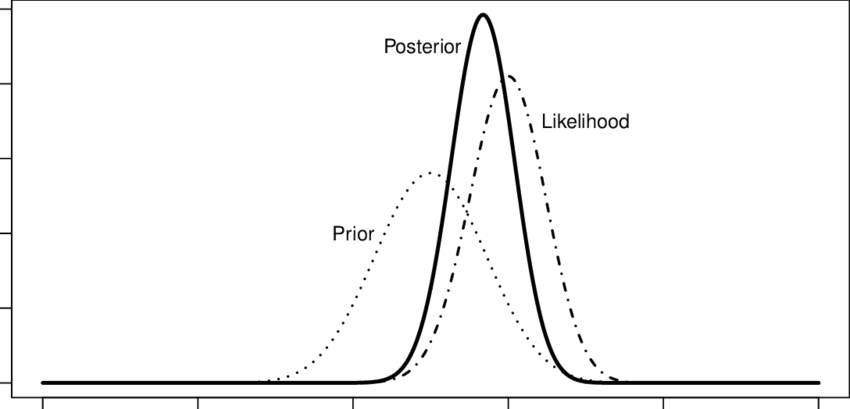</div>

<div align="center" style="color:darkblue">https://www.researchgate.net/figure/Bayesian-updating-of-the-prior-distribution-to-posterior-distribution-The-Posterior_fig1_320507985</div>



### Conjugate priors

If the posterior distribution $p(\theta|x)$ belongs to the same family as the prior distribution $p(\theta)$, then the prior is said to be a **conjugate prior** for the likelihood function $p(x|\theta)$.
This is a particularly convenient case in which the posterior distribution has a closed-form expression.

These are just a few examples of conjugate priors:

|Conjugate prior distribution| Likelihood | Prior hyperparameters | Posterior hyperparameters|
|:------:|:-----:|:-----:|:------:|
|Normal|Normal (known var.)|$$\mu_0,\sigma_0^2$$|$${\frac{1}{\frac{1}{\sigma_0^2}+\frac{n}{\sigma^2}}\Bigg(\frac{\mu_0}{\sigma_0^2}+\frac{\sum_{i=1}^n x_i}{\sigma^2}\Bigg),\Bigg(\frac{1}{\sigma_0^2}+\frac{n}{\sigma^2}\Bigg)^{-1}}$$|
|Inverse Gamma|Normal (known mean)|$$\alpha,\beta$$|$$\alpha+\frac{n}{2},\beta+\frac{\sum_{i=1}^n (x_i-\mu)^2}{2}$$|
|Beta|Binomial|$$\alpha,\beta$$|$$\alpha+\sum_{i=1}^n x_i, n-\sum_{i=1}^n x_i+\beta$$|
|Gamma|Poisson|$$k,\theta$$|$$k+\sum_{i=1}^n x_i,\frac{\theta}{n\theta+1}$$|
|Gamma|Exponential|$$\alpha,\beta$$|$$\alpha+n,\beta+\sum_{i=1}^n x_i$$|

**Beta-Binomial case**

$Beta(\alpha,\beta)$ prior and $x\sim Bin(n,\pi)$ likelihood result in the posterior

\begin{align}
p(\pi|x,\alpha,\beta)&\propto \pi^x (1-\pi)^{n-x} \pi^{\alpha-1}(1-\pi)^{\beta-1}\\
                     &\propto \pi^{x+\alpha-1}(1-\pi)^{n-x+\beta-1}
\end{align}

which is a $Beta(x+\alpha, n-x+\beta)$.

### Approximate inference

Prior $p(\theta)$ and likelihood $p(x|\theta)$ functions are usually known as part of the model, while the computation of the normalization factor 

$$
p(x) = \int_\theta p(x|\theta) p (\theta) d \theta
$$

can easily become intractable in the high-dimensional cases.

**Example of intractable posterior**

Suppose we are trying to figure out how much something weighs, but the scale we’re using is unreliable and gives slightly different answers every time we weigh the same object. We could try to compensate for this variability by integrating the noisy measurement information with a guess based on some *prior knowledge* about the object.

$$weight \, | \, guess \sim \mathcal{N}(guess, 1)$$

$$ measurement \, | \, guess, weight \sim \mathcal{N}(weight, 0.75^2) $$

In [5]:
def scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    measurement = pyro.sample("measurement", dist.Normal(weight, 0.75))
    return measurement

The model is quite simple, so we are able to determine our posterior distribution of interest analytically. But in general the exact computation of the posterior of an arbitrary stochastic function is intractable. 

Even the `scale` model with a non-linear function may become intractable.

In [6]:
def intractable_scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    measurement = pyro.sample("measurement", 
                              dist.Normal(some_nonlinear_function(weight), 0.75))
    return measurement

Approximate inference addresses the need of applying Bayesian learning to more complex problems and to the high-dimensional datasets that we are dealing with in machine learning.

Examples of approximate inference include Variational Bayesian methods, Markov chain Monte Carlo, Markov Random Fields and Bayesian Networks.
We can identify two main categories for approximate inference:
- **Stochastic methods** turn the problem of inference into a problem of sampling from the posterior distribution of interest;
- **Deterministic methods** substitute inference with optimization problems.

## References
- S. Wood, "Core Statistics"
- [Pyro library](https://pyro.ai/)
- [Pyro documentation](https://docs.pyro.ai/en/1.1.0/index.html)
- [Probabilistic Programming & Bayesian Methods for Hackers](https://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/)